# Example of field-free orientation of OCS molecule using THz field

Use strong, up to 1MV/cm, THz pulses to produce field-free alignment and orientation of OCS molecule.

We take the THz pulse profile from Fig. 4 in X. Wu, A.-L. Calendron, K. Ravi, et. al, "Optical generation of single-cycle 10 MW peak power 100 GHz waves", *Optics Express* **24**, 21059-21069 (2016), https://doi.org/10.1364/OE.24.021059.

In [1]:
import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
from scipy.interpolate import interp1d

from richmol import DIP_X_FIELD_INVCM, CartTensor, RotStates, propagate_rk

Define molecule and its properties, compute rotational states and matrix elements.

In [2]:
xyz = (
    "C",  0.0,  0.0,  -0.522939783141,
    "O",  0.0,  0.0,  -1.680839357,
    "S",  0.0,  0.0,  1.037160128,
)

# rotational states
jmax = 10
states = RotStates.from_geometry(jmax, xyz)

# molecular-frame dipole moment (in au)
dip = [0, 0, -0.31093]

# molecular-frame polarizability tensor (in au)
pol = [
    [25.5778097, 0, 0],
    [0, 25.5778097, 0],
    [0, 0, 52.4651140],
]

# rotational matrix elements of laboratory-frame
# dipole and polarizability tensors
dip = CartTensor(states, dip)
pol = CartTensor(states, pol)


Compute rigid-rotor solutions using molecular geometry as input
Cartesian units: angstrom, conversion to Angstrom: 1
  Atom           Mass (u)              X (Å)              Y (Å)              Z (Å)
     C    12.000000000000     0.000000000000     0.000000000000    -0.522939783141
     O    15.994914619260     0.000000000000     0.000000000000    -1.680839357000
     S    31.972071173540     0.000000000000     0.000000000000     1.037160128000
Symmetry group: c1
Molecule is linear
G-matrix (cm^-1):
 [[0.40687878 0.         0.        ]
 [0.         0.40687878 0.        ]
 [0.         0.         0.        ]]


/Users/yachmena/.venvs/myenv/lib/python3.13/site-packages/richmol/asymtop.py:211: RuntimeWarning: divide by zero encountered in divide
  d = np.where(sv > G_SING_TOL, 1 / sv, 0)


solve for J = 0 and symmetry A ...
solve for J = 1 and symmetry A ...
solve for J = 2 and symmetry A ...
solve for J = 3 and symmetry A ...
solve for J = 4 and symmetry A ...
solve for J = 5 and symmetry A ...
solve for J = 6 and symmetry A ...
solve for J = 7 and symmetry A ...
solve for J = 8 and symmetry A ...
solve for J = 9 and symmetry A ...
solve for J = 10 and symmetry A ...
  J Irrep    i         Energy (E)      (J,k,tau,Irrep)           c_max²
  0     A    0         0.00000000       (0, 0, 0, 'A')   1.000000000000
  1     A    0         0.40687878       (1, 0, 1, 'A')   1.000000000000
  2     A    0         1.22063633       (2, 0, 0, 'A')   1.000000000000
  3     A    0         2.44127266       (3, 0, 1, 'A')   1.000000000000
  4     A    0         4.06878777       (4, 0, 0, 'A')   1.000000000000
  5     A    0         6.10318165       (5, 0, 1, 'A')   1.000000000000
  6     A    0         8.54445431       (6, 0, 0, 'A')   1.000000000000
  7     A    0        11.39260575     

Initialize THz field, use pulse profile provided in file [thz_field.csv](thz_field.csv).

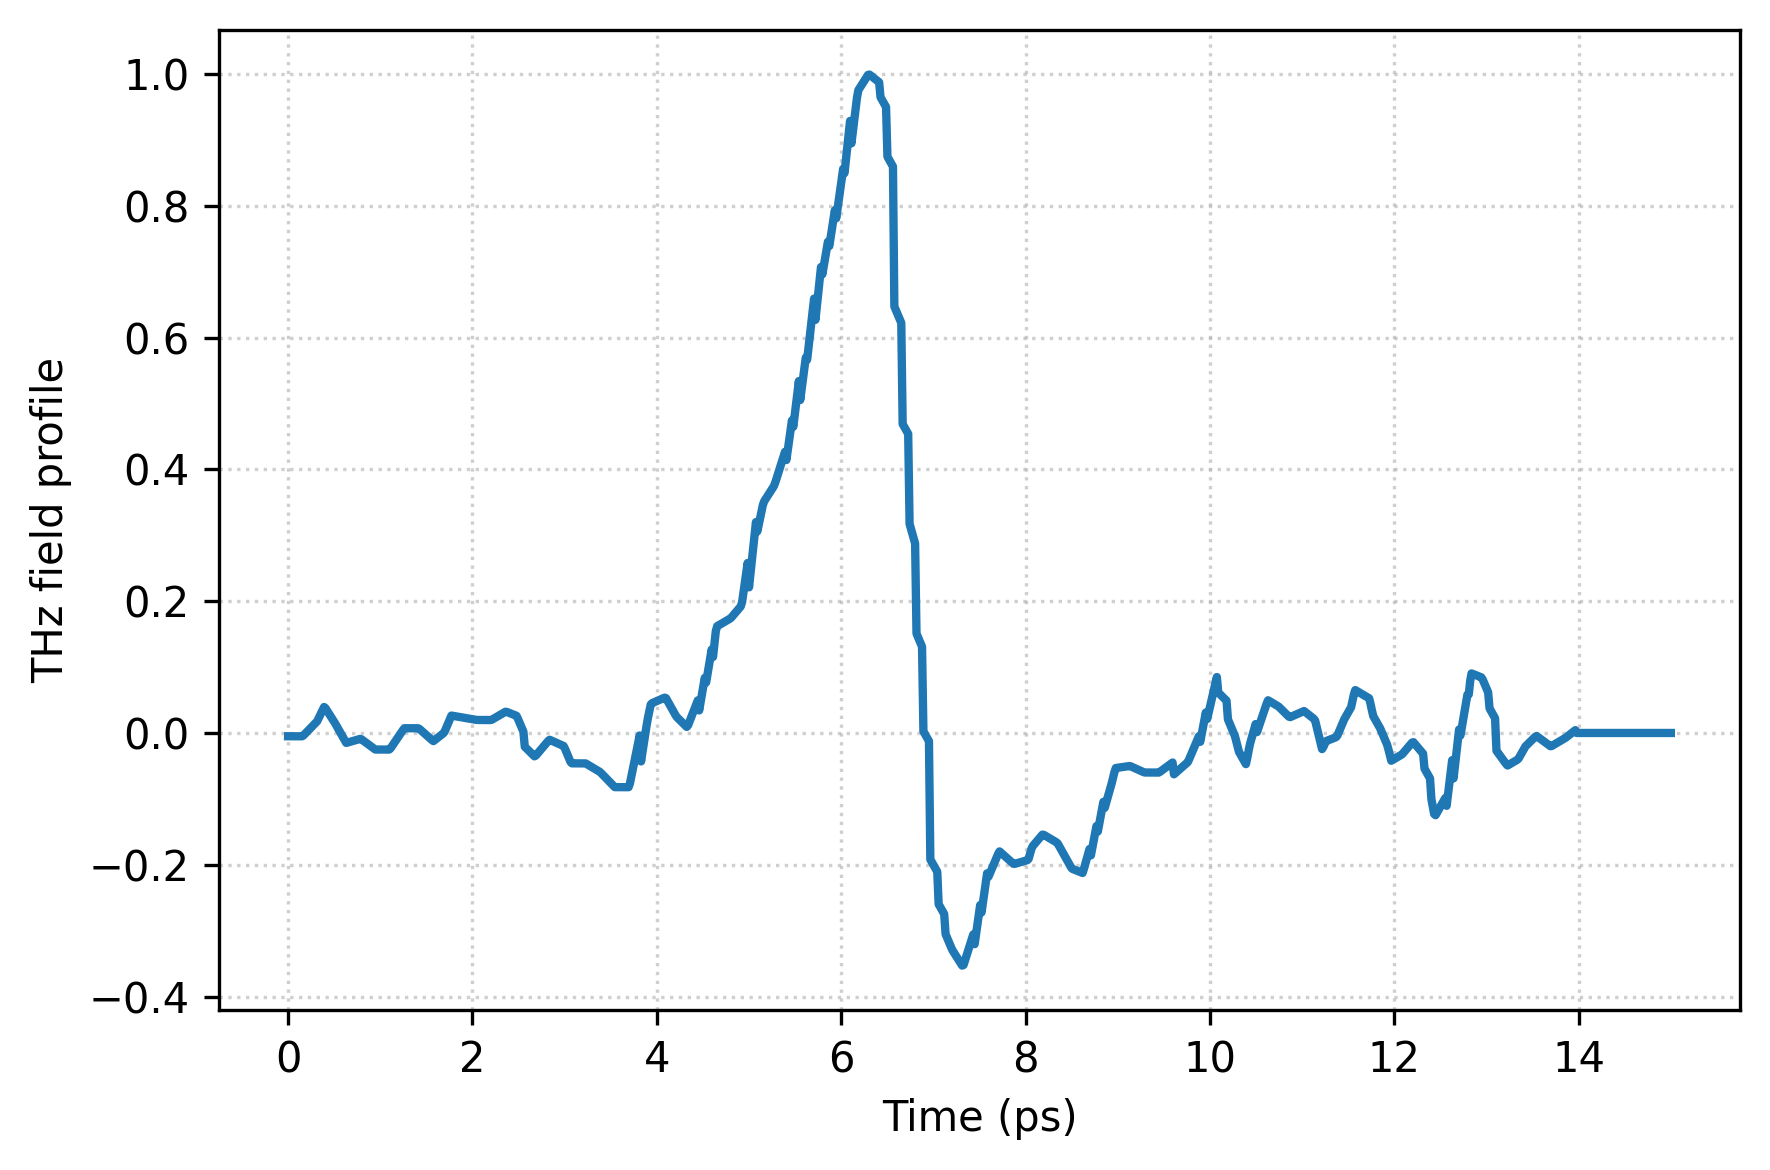

In [3]:
with open("thz_field.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=";")
    _field = np.array(
        [[float(elem.replace(",", ".")) for elem in row] for row in csv_reader]
    )
    _field -= [np.min(_field.T[0]), 0]
    _field /= [1, np.max(_field.T[1])]
    _f_field = interp1d(*_field.T, fill_value=0, bounds_error=False)


def field_z(time, peak_field):
    return _f_field(time) * peak_field


plt.figure(figsize=(6, 4), dpi=300)

t = np.linspace(0, 15, 1000)
plt.plot(t, field_z(t, peak_field=1), linewidth=2)
plt.xlabel("Time (ps)")
plt.ylabel("THz field profile")
plt.grid(True, linestyle=":", alpha=0.6)
plt.yticks(fontsize=10)
plt.tight_layout()

Solve TDSE for OCS rotations in THz field.

In [4]:
# initial wavepacket: J=0 state
c0 = np.zeros(states.mat().shape[0], dtype=np.complex128)
c0[0] = 1.0

# THz field along the Z direction
peak_field = 1e6  # 1MV/cm
field_au = constants.value("atomic unit of electric field")
field_func = lambda t: np.array(
    [0, 0, field_z(t, peak_field=peak_field * 100 / field_au)]
)

time, c_t = propagate_rk(
    states,
    [dip],
    [-DIP_X_FIELD_INVCM],
    field_func=field_func,
    t0=0,
    t1=500,
    time_unit="ps",
    c0=c0,
)

Plot state populations.

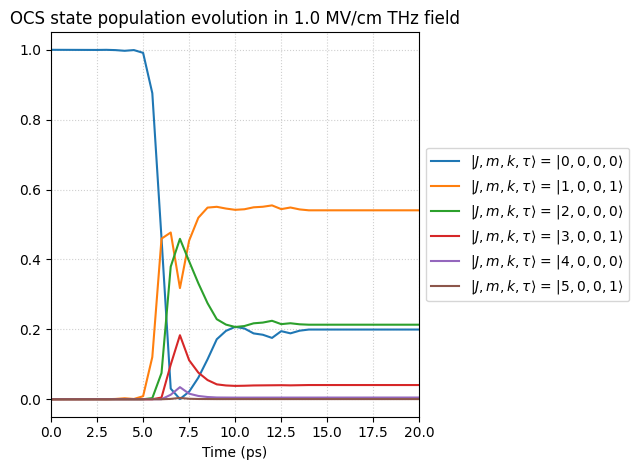

In [5]:
# state populations
pop_t = np.abs(c_t) ** 2

# states with nonzero populations
state_ind = np.any(np.abs(pop_t) > 1e-3, axis=0).nonzero()[0]
state_qua = [
    f"$|J,m,k,\\tau\\rangle$ = $|{j}, {m}, {k}, {tau}\\rangle$" for (j, m, k, tau, *_) in states.quanta[state_ind]
]

plt.plot(time, pop_t[:, state_ind], label=state_qua)
plt.xlim([0, 20])

plt.title(f"OCS state population evolution in {round(peak_field/1e6, 1)} MV/cm THz field")
plt.xlabel("Time (ps)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, loc="center left", bbox_to_anchor=(1, 0.5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Compute and plot alignment functions $\cos\theta$, $\cos\theta_{2D}$, $\cos^2\theta$, and $\cos^2\theta_{2D}$, using Monte-Carlo approach.

In [6]:
expval = []
nbatches = 10
for ibatch, c in enumerate(np.split(c_t, nbatches)):
    print(f"batch {ibatch+1}/{nbatches}")
    expval.append(states.mc_costheta(c.T))
cost, cost_sq, cost2d, cost2d_sq = np.concatenate(expval, axis=-1)

batch 1/10
batch 2/10
batch 3/10
batch 4/10
batch 5/10
batch 6/10
batch 7/10
batch 8/10
batch 9/10
batch 10/10


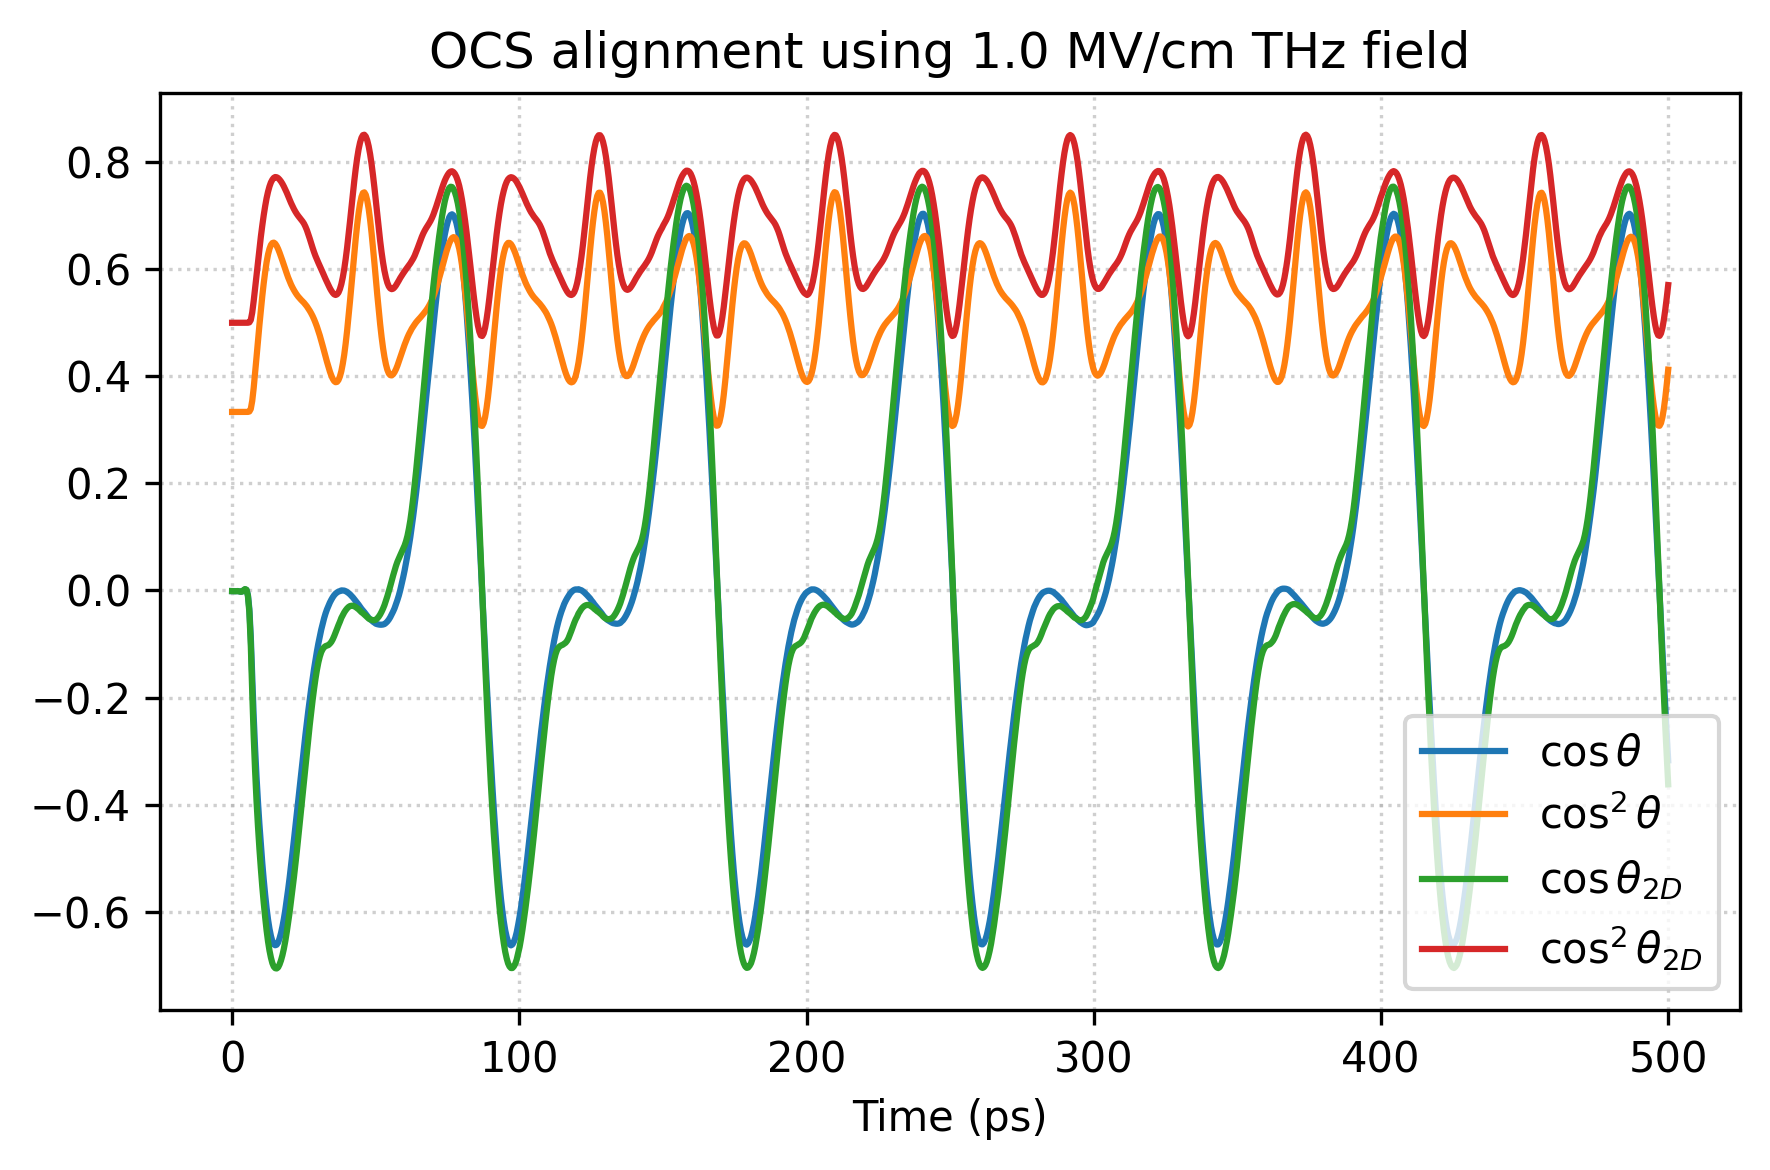

In [7]:
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(time, cost, linewidth=1.5, label="$\\cos\\theta$")
plt.plot(time, cost_sq, linewidth=1.5, label="$\\cos^2\\theta$")
plt.plot(time, cost2d, linewidth=1.5, label="$\\cos\\theta_{2D}$")
plt.plot(
    time,
    cost2d_sq,
    linewidth=1.5,
    label="$\\cos^2\\theta_{2D}$",
)
plt.title(f"OCS alignment using {round(peak_field/1e6, 1)} MV/cm THz field")
plt.xlabel("Time (ps)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, loc="lower right")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()